In [1]:
#pip install yfinance

In [2]:
#pip install pmdarima 

In [3]:
import pandas as pd
import yfinance as yf
import datetime

import pmdarima as pm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
start_training = datetime.date(2010, 1, 1)
end_training = datetime.date(2023, 4, 15)
start_testing = datetime.date(2023, 4, 16)
end_testing = datetime.datetime.today()
ticker = "ASHOKLEY.NS"

In [5]:
df_training = yf.download(ticker, start=start_training, end=end_training, progress=False)
print(f"Downloaded {df_training.shape[0]} rows and {df_training.shape[1]} columns of {ticker} data")

Downloaded 3278 rows and 6 columns of ASHOKLEY.NS data


In [6]:
df_training.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-06,136.300003,137.649994,135.250000,136.449997,134.303131,9954768
2023-04-10,136.949997,138.949997,136.500000,138.199997,136.025604,8906284
2023-04-11,138.899994,139.500000,137.100006,137.550003,135.385834,8436245
2023-04-12,137.850006,138.800003,136.899994,137.500000,135.336609,8066242
2023-04-13,137.850006,138.899994,137.399994,138.000000,135.828751,8297796


In [7]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month of the month
## 'Close' : closing price of the month
## 'Adj Close' : adjusted closing price of the month

df_training = df_training.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 'Close':'last', 
                                             'Adj Close':'last'})

In [8]:
df_training.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df_training.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df_training.tail())

             adj_close
Date                  
2023-03-19  137.305145
2023-03-26  135.484253
2023-04-02  137.009857
2023-04-09  134.303131
2023-04-16  135.828751


In [9]:
start_training_str = (start_training + pd.Timedelta("5 days")).strftime("%B %Y")
end_training_str = (end_training - pd.Timedelta("5 days")).strftime("%B %Y")

<Axes: title={'center': 'ASHOKLEY.NS weekly adjusted close prices (January 2010 - April 2023)'}, xlabel='Date'>

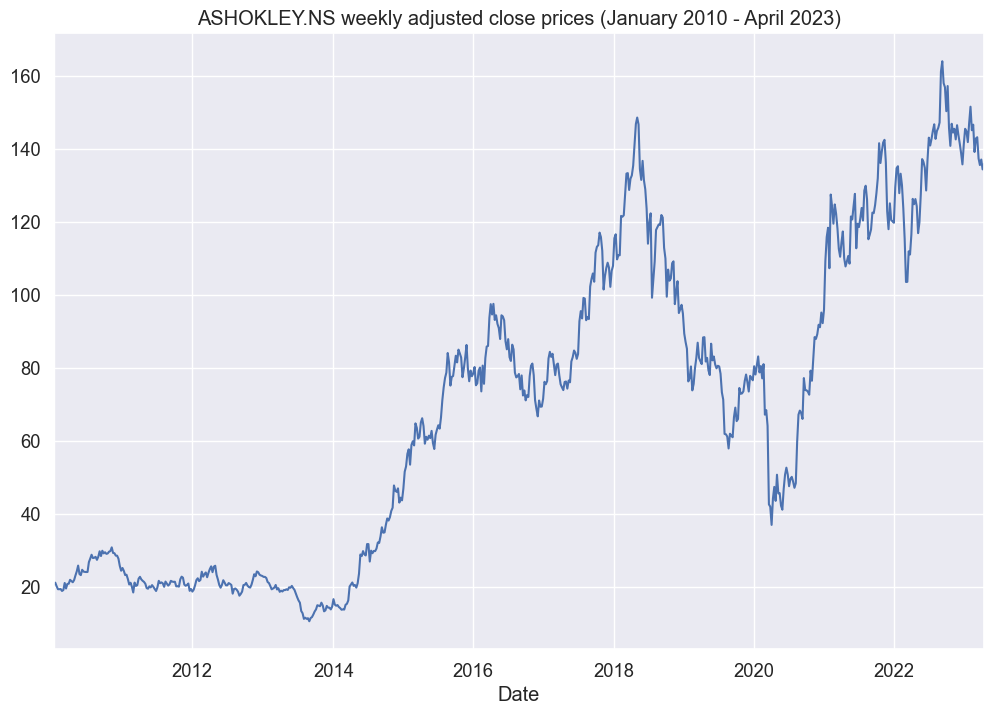

In [10]:
sns.set(font_scale=1.2)
df_training['adj_close'].plot(figsize=(12, 8), 
                     title=f"{ticker} weekly adjusted close prices ({start_training_str} - {end_training_str})")

In [11]:
## Fitting the model(With more tuning of the parameters)
arima_fit = pm.auto_arima(df_training['adj_close'], error_action='ignore', suppress_warnings=True, stepwise=False, 
                           approximation=False, seasonal=False)

## Printing a summary of the model
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  693
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1921.549
Date:                Sat, 18 Nov 2023   AIC                           3853.097
Time:                        16:15:08   BIC                           3875.795
Sample:                    01-10-2010   HQIC                          3861.876
                         - 04-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3281      0.281      1.166      0.243      -0.223       0.879
ar.L1         -0.8681      0.083    -10.428      0.000      -1.031      -0.705
ar.L2         -0.0982      0.033     -2.932      0.003      -0.164      -0.033
ma.L1          0.8439      0.077     10.960      0.000       0.693       0.995
sigma2        15.1141      0.465     32.500      0.000      14.203      16.026
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               675.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              23.65   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
df_testing = yf.download(ticker, start=start_testing, end=end_testing, progress=False)
print(f"Downloaded {df_testing.shape[0]} rows and {df_testing.shape[1]} columns of {ticker} data")

Downloaded 148 rows and 6 columns of ASHOKLEY.NS data


In [13]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

df_testing = df_testing.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 'Close':'last', 'Adj Close':'last'})

In [14]:
df_testing.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df_testing.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df_testing.head())

             adj_close
Date                  
2023-04-23  134.106277
2023-04-30  143.653656
2023-05-07  142.226471
2023-05-14  147.393875
2023-05-21  152.265991


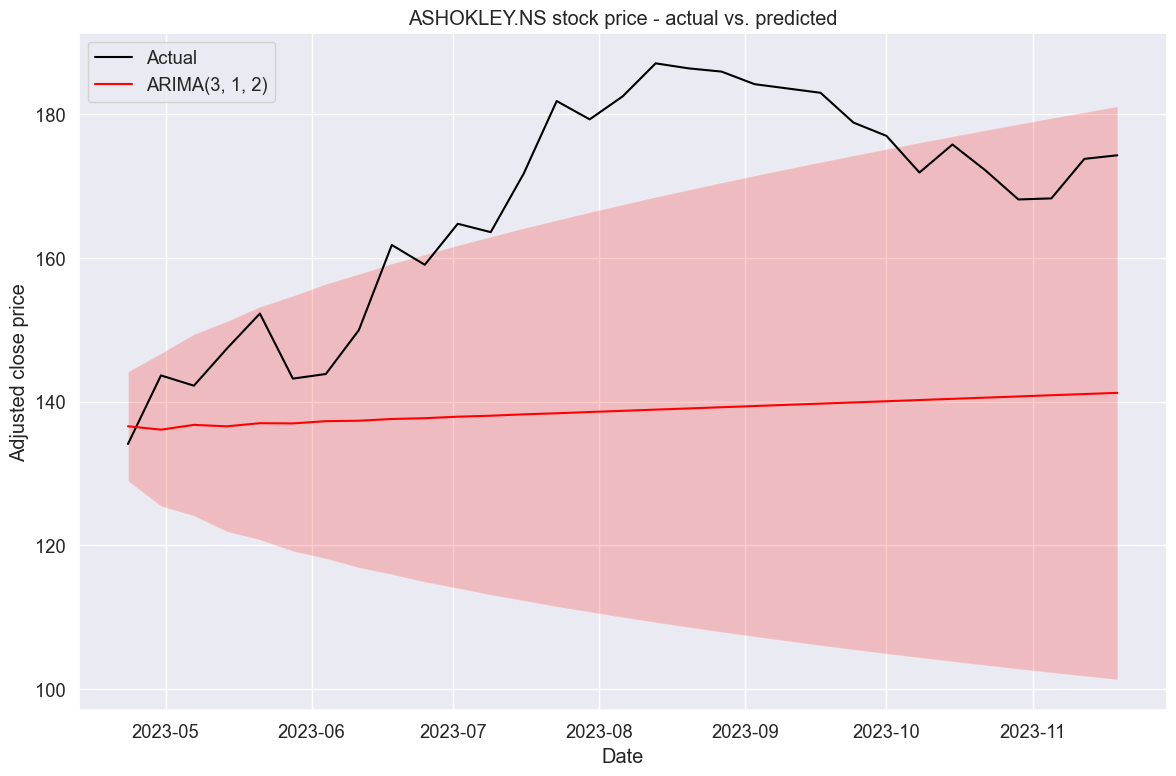

In [15]:


# Forecasting
n_fcast1 = len(df_testing)
arima_fcast, conf_int = arima_fit.predict(n_periods=n_fcast1, return_conf_int=True, alpha=0.05)
arima_fcast_df = pd.DataFrame(arima_fcast, columns=['prediction'], index=df_testing.index)
conf_int_df = pd.DataFrame(conf_int, columns=['lower_95', 'upper_95'], index=df_testing.index)

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_testing['adj_close'], color='black', label='Actual')
ax.plot(arima_fcast_df['prediction'], color='red', label='ARIMA(3, 1, 2)')
ax.fill_between(conf_int_df.index, conf_int_df['lower_95'], conf_int_df['upper_95'], alpha=0.2, facecolor='red')

ax.set(title=f"{ticker} stock price - actual vs. predicted", xlabel='Date', ylabel='Adjusted close price')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()
